In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import scipy.io



## Load data

##### Load IAM-Handwritten-Database words

In [6]:
iam_db_words_images_path = np.array([])

# Define root folder for IAM database
iam_words_root = './data/IAM-Handwritten-Database/words/'
sub_directories = sorted(list(map( lambda sub_directory: iam_words_root + sub_directory, os.listdir(iam_words_root))))

# Loop over each subdirectory
for sub_directory in sub_directories:
    forms = sorted(list( map( lambda form: sub_directory + '/' + form, os.listdir(sub_directory) ) ))
    # Loop over each form subdirectory
    for form in forms:
        # Append file paths
        files = sorted(list( map( lambda file: form + '/' + file, os.listdir(form) ) ))        
        iam_db_words_images_path = np.append(iam_db_words_images_path, files)

# Read label file and remove first 18 lines because they are useless
iam_db_words_label_file = open('./data/IAM-Handwritten-Database/words.txt').readlines()[18:]

# For each line, take only what's after 8 spaces
# If the word itself contains spaces we join into one string
iam_db_words_labels = list(
    map(
        lambda line: ' '.join(line.split()[8:]),
        iam_db_words_label_file
    )
)

iam_db_words_images_path = iam_db_words_images_path.tolist()


#### Load The IIIT 5K-word dataset

In [7]:
iit_5k_word_root = './data/IIIT5K-Word_V3.0/IIIT5K/'

# Create empty arrays
iit_5k_word_images_path = []
iit_5k_word_labels = []

# We will mix both test and train dataset so we load both datasets and add data to our
# Add data of test dataset
testdata = scipy.io.loadmat(iit_5k_word_root + 'testdata.mat')['testdata'][0]
for data in testdata:
    iit_5k_word_images_path.append(iit_5k_word_root + data[0][0])
    iit_5k_word_labels.append(data[1][0])

# Add data of train dataset
traindata = scipy.io.loadmat(iit_5k_word_root + 'traindata.mat')['traindata'][0]
for data in traindata:
    iit_5k_word_images_path.append(iit_5k_word_root + data[0][0])
    iit_5k_word_labels.append(data[1][0])



MemoryError: 

## Data preprocessing

#### Create various utility variables as well as training and validation sets

In [5]:

images_path = iam_db_words_images_path[:5000] + iit_5k_word_images_path
labels = iam_db_words_labels[:5000] + iit_5k_word_labels

# Get all the characters in all labels, remove duplicate values with set() and sort values with sorted()
characters = sorted(list(set(char for label in labels for char in label)))
# Batch size for training and validation
batch_size = 64

# Desiered image dimensions
image_width = 200
image_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any label
max_length = max([len(label) for label in labels])

# Mapping characters to integer
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)
# Mapping characters integer back to original characters
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

# Define max authorized length for input
max_authorized_length = 50

# Remove labels and images when labels is sup to given length
indices_to_remove = []
for i in range(len(labels)):
    if i >= len(labels): break;
    if len(labels[i]) > max_authorized_length or os.stat(images_path[i]).st_size <= 0:
        del images_path[i]
        del labels[i]
        i = i-1

# Function to split the dataset between training and validation set and add possibility to shuffle data
def split_data(images_path, labels, train_size=0.9, shuffle=True):
    # Get the total size of the dataset
    dataset_size = len(images_path)
    # Create an indices array and shuffle it if required
    indices = np.arange(dataset_size)
    if shuffle: np.random.shuffle(indices)
    # Get the size of the training sample by multiplying by the train size
    train_samples_size = int(dataset_size * train_size)
    # Finally, split data into training and validation sets
    x_train, y_train = images_path[indices[:train_samples_size]], labels[indices[:train_samples_size]]
    x_valid, y_valid = images_path[indices[train_samples_size:]], labels[indices[train_samples_size:]]
    return x_train, x_valid, y_train, y_valid



# Get max length in labels
max_length = max([len(label) for label in labels])

# Add zero at the end of each label until it reaches max_length
labels = [label + "0" * (max_length - len(label)) for label in labels]

# # Create training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images_path), np.array(labels))



#### Create datasets objects

In [4]:
# Function to encode a single sample into the following form : {"image": image_array, "label": label}
# This function will be used later on right after the dataset object creation
def encode_single_sample(image_path, label):
    # Read the image with tensorflow
    image = tf.io.read_file(image_path)
    # Decode and convert to gray scale (whith channel = 1), we don't need colors to get the label of an image
    image = tf.io.decode_png(image, channels=1)
    print(image)
    exit(0)
    # Convert image array into float32 in range [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize image to the desired size
    image = tf.image.resize(image, [image_height, image_width])
    # Transpose the image data array because we want the third dimension to corresponde to the width
    image = tf.transpose(image, perm=[1, 0, 2])
    # Map the label characters to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # Return the corresponding dictionary
    return {"image": image, "label": label}

# Create training and validation datasets
# We map ver the newly created dataset and apply our function encode_single_sample
# batch() divides dataset into several batches of desired size
# prefect() prefetch data in memory and allow a quicker access to it
# tf.data.AUTOTUNE lets tensorflow decides the best tunning algorithm or value for the function it is called upon

train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)
).map(
    encode_single_sample,
    num_parallel_calls=tf.data.AUTOTUNE
).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices(
    (x_valid, y_valid)
).map(
    encode_single_sample,
    num_parallel_calls=tf.data.AUTOTUNE
).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)



NameError: name 'x_train' is not defined

In [6]:

# CTC = Connectionist Temporal Classification, méthode connectable dans des réseaux de neurones
# permettant entre autre d'identifier des séquences de données temporelles

# The CTC alorithms assign a probability for any Y given an X. Its goal is to allign the input and the output.
# For example in an OCR, it will assign each output a propability for a given handwritten chatacter

# Convolutional block :
#    - Convolutional Layer : aid in dedetecing patterns in our image
#    - Pooling layers : 
#           The problem with the convolutional layers is that they record the precise position
#           of features in the input. This leans that small movements in the position of the feature in
#           input image will result in a different feature map. Thic can happen with re-cropping, rotation,
#           shiffting of the input image.
#           To overcome this problem, a common approach is down sampling the input. A lower resolution is apply
#           but it still contains the large or important structural elements, witout the fine details that may not
#           be useful to the task. It is done by using a pooling layer.
#           Pooling involves selecting a pooling operation. It is like applying a filter to each feature map to make it
#           smaller. For exammple; if it reduces the feature map by a factor of 2, each dimension is halved, this means
#           that the feature map will have the quarter of it's original size. 6*6 (36 pixels) => 3*3 (9 pixels).
#           The pooling operation is specified, rather than learned, thow common pooling functions are :
#               - Average pooling : Calculate the average value for each patch on the feature map
#               - Maximum pooling : Calculate the maximum value for each path on the feature map
#           The result is a summarized version of the features detected in the input. They are useful because small changes
#           in the input will produce the same feature map. Thid capability added by pooling is called "the model's invariance
#           to local translation".
#           pooling helps to make the representaion become approximately invariant to small translations of the input. If we translate
#           the input by a small amount, the values of most of the pooled outputs do not change.
#   - Dropout layer :
#       Neural networks tends to memorize the input data instead of learning procedures and working. We can use a dropout layer to reduce this
#       this effect. The dropout layers randomly discard sme of the input data that passes trhough it. To summarize, we discard data to obtain a 
#       more accurate end results.

# Define CTCLayer class :

class CTCLayer(layers.Layer):
    def __init__(self, name=None) -> None:
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost #we use the batch_cost loss function
    
    def call(self, y_true, y_pred):
        # Compute the training-time loss vaue and add it
        # to the layer using `self.add_loss()`
        # tf.shape() = get the shape of the tensor (tensor = one or multi dimensional array e.g. a bit like numpy arrays). Returns also a tensor
        # tf.cast() = cast the given tensor into specified dtype
        # tf.ones () = create a tensor of the given shape fullfilled with ones (1) : ex : [[1, 1, 1], [1, 1, 1]]
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(image_width, image_height, 1), name="image", dtype="float32")
    labels = layers.Input(shape=(None, ), name="label", dtype="float32")

    #First conv block
    # layers.Convo2D() creates a 2D convolution layer (e.g. spatial convolution over images)
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1"
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2"
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    # RNN = Recurent Neural Network
    # This is a type if algorithm that remember its input, due t an internal memory, which make it well suited for machine learning
    # problems that involve sequential data. With sequential or time series data, feedforwars networks cannot be used for learning and
    # prediction. A mechanism (RNN for example) is required to retain past or historical information to forecast future values.
    # Recurent Neural Network (RNN) are a variant of the conventional feedforward artificial neural networks that can dead with
    # sequential data and can be trained to hold knowledge about the past.
    
    # LSTM (Long Short Term Memory) = modified version of recurrent neural networks, which make it easier to remember past data in memory.
    # LSTM is well suited to classify, process and predict time series given time lags of unknown duration.
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    
    # Outpout layer
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at eacgh step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_model_v1")

    # Optimizer
    # Optimizers are algorithms used to update tje âraùeters of a neural networks such as weights and learning rate to reduce the losses.
    # Optimizers are used to solve optimizatio problems by minimizing the cost function.
    opt = keras.optimizers.Adam()

    # Compile the model
    model.compile(optimizer=opt)

    # Return the model
    return model

# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

In [7]:
epochs = 10
# Early stopping is a method that allows you to specify an arbitrarily large number of training epocs
# #and stop training once the model performance stop improving on the validation dataset
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/10
141/141 [==============================] - 21s 94ms/step - loss: 36.0200 - val_loss: 28.6816
Epoch 2/10
141/141 [==============================] - 11s 81ms/step - loss: 27.5901 - val_loss: 25.7088
Epoch 3/10
141/141 [==============================] - 11s 80ms/step - loss: 24.7664 - val_loss: 18.9350
Epoch 4/10
141/141 [==============================] - 13s 89ms/step - loss: 18.6885 - val_loss: 18.0107
Epoch 5/10
141/141 [==============================] - 13s 93ms/step - loss: 18.0101 - val_loss: 17.6442
Epoch 6/10
141/141 [==============================] - 14s 97ms/step - loss: 17.5779 - val_loss: 17.2691
Epoch 7/10
141/141 [==============================] - 14s 97ms/step - loss: 17.4075 - val_loss: 17.1007
Epoch 8/10
141/141 [==============================] - 13s 92ms/step - loss: 17.1576 - val_loss: 16.8951
Epoch 9/10
141/141 [==============================] - 14s 99ms/step - loss: 16.8899 - val_loss: 16.6746
Epoch 10/10
141/141 [==============================] - 14s 97ms/

## Save the model

In [8]:
model.save('./CNN-OCR-MODEL-SAVE/')


INFO:tensorflow:Assets written to: ./CNN-OCR-MODEL-SAVE/assets


INFO:tensorflow:Assets written to: ./CNN-OCR-MODEL-SAVE/assets


## Load model

In [9]:
model = tf.keras.models.load_model('./CNN-OCR-MODEL-SAVE/')

## Evaluate the model

2/2 [==============================] - 1s 10ms/step


IndexError: index 4 is out of bounds for axis 0 with size 4

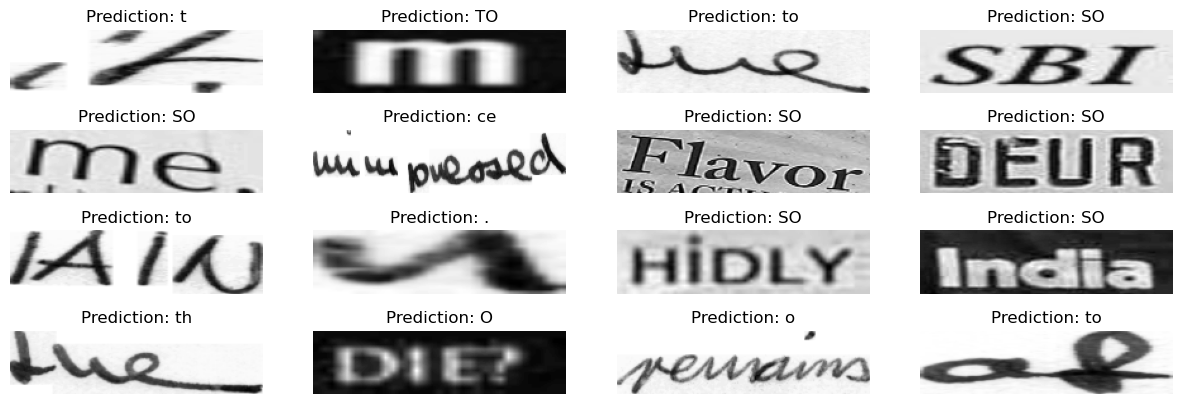

In [11]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8").replace('[UNK]', '').strip('0')
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()